In [1]:
# !apt-get install -y libsndfile1

In [2]:
!pip install PySoundFile
!pip install scikit-maad
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.2/167.2 kB 14.0 MB/s eta 0:00:00


In [3]:
# Core ML & GPU
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from torch.utils.data import Dataset
#import tensorflow_io as tfio
#import keras_cv
#from keras.callbacks import EarlyStopping

# scikit-learn maad for when u want to grrr
from maad import sound, features as maad_features

# Huggingface Transformers
from transformers import AutoFeatureExtractor, TFViTModel #TFViTForImageClassification #TFViTModel #TFAutoModel #TFWhisperModel #, TFWhisperEncoder #TFWhisperModel
from transformers import AutoModelForAudioClassification
#from transformers.models.whisper.modeling_tf_whisper import TFWhisperEncoder
from huggingface_hub import login

# Dataloading
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import glob #for finding TFRecord files

# Colab specific
from google.colab import userdata

from tqdm.auto import tqdm

import plotly.express as px

# Utilities
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# MOUNT GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')
#!cp -r "/content/drive/My Drive/tfrecords" /content/
# !cp -r "/content/drive/MyDrive/rfcx-species-audio-detection" /content/
#print("rfcx-species-audio-detection copied successfully.")
# drive.flush_and_unmount()

Mounted at /content/drive


In [5]:
# UNZIP FILE FROM DRIVE INTO DRIVES /content/ unzipped

ZIP_FILE_PATH = "/content/drive/MyDrive/rfcx-species-audio-detection.zip"

UNZIP_DESTINATION = "/content/rfcx_local_data/"

print(f"Unzupping {ZIP_FILE_PATH} to {UNZIP_DESTINATION} . . . ")
os.makedirs(UNZIP_DESTINATION, exist_ok=True)

!unzip -q -o "{ZIP_FILE_PATH}" -d "{UNZIP_DESTINATION}"

print("I took the zip and I unzipped the zip so now the zip is unzipped and ready")

Unzupping /content/drive/MyDrive/rfcx-species-audio-detection.zip to /content/rfcx_local_data/ . . . 
I took the zip and I unzipped the zip so now the zip is unzipped and ready


In [6]:
# !cp -r "/content/drive/MyDrive/rfcx-species-audio-detection" /content/

In [7]:
# MODEL DEFINITION CELL

#from transformers import ASTFeatureExtractor
#from transformers import TFASTModel

model_checkpoint = "google/vit-base-patch16-224-in21k"
#model_checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
num_species = 24

print("Loading ViT feature extractor and BASE model . . . ")
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
base_model = TFViTModel.from_pretrained(model_checkpoint, from_pt=True)

#feature_extractor = ASTFeatureExtractor.from_pretrained(model_checkpoint)
#base_model = TFASTModel.from_pretrained(model_checkpoint, from_pt=True)

class BiodiversityModel(tf.keras.Model):
  def __init__(self, vit_base_model):
    super().__init__()

    self.vit = vit_base_model

    #self.regressor = layers.Dense(1, activation='sigmoid', name='biodiversity_score')

    self.head_stack = tf.keras.Sequential([
        layers.LayerNormalization(name="head_norm"),
        layers.Dense(256, activation='gelu', name="head_dense_1"),
        layers.Dropout(0.3, name="head_dropout"),
        layers.Dense(1, activation='sigmoid', name='biodiversity_score', bias_initializer='zeros')
    ], name='regression_head')

  def call(self, inputs, training=None, explain=False):

    transposed_inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])

    # hidden_states = self.vit(
    #     pixel_values=transposed_inputs,
    #     training=training,
    # )

    vit_outputs = self.vit(
        pixel_values=transposed_inputs,
        training=training,
        output_attentions=explain # added this to make heatmap pred work
    )

    last_hidden_state = vit_outputs.last_hidden_state

    cls_token_output = last_hidden_state[:, 0, :]

    #final_score = self.regressor(cls_token_output)
    final_score = self.head_stack(cls_token_output, training=training)

    if explain:
      #last_hidden_state = vit_outputs.last_hidden_state
      return final_score, vit_outputs.attentions

    return final_score

print('\nBuilding the final model with the custom ViT layer . . .')
model = BiodiversityModel(base_model)

model.vit.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

print('\n Ayo son we got it, the ViT model is build correctly and im ready to pull it')

dummy_input = tf.ones((1, 224, 224, 3))
model(dummy_input)
model.summary()

Loading ViT feature extractor and BASE model . . . 


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.



Building the final model with the custom ViT layer . . .

 Ayo son we got it, the ViT model is build correctly and im ready to pull it


Model: "biodiversity_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ regression_head (Sequential)    │ (1, 1)                 │       198,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,657 (776.00 KB)

 Trainable params: 198,657 (776.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# model.vit.summary()

# model.vit.layers[0].encoder.summary()

In [9]:
def calculate_adi(audio, sr, n_fft=2048, hop_length=512):
  try:

    peak_amplitude = np.max(np.abs(audio))

    if peak_amplitude > 1e-5:
      audio = audio / peak_amplitude

    # 1. Calculate the spectrogram (power)
    # need the power spectrogram (Sxx), not the log-mel spectrogram
    Sxx, _, freqs, _ = sound.spectrogram(audio, sr, n_fft=n_fft, hop_length=hop_length, window='hann', flim=(0, 8000))

    # 2. Calculate ADI
    # focus only on traditional biophony band (2k-11k)

    fmin = 2000.0
    fmax = 8000.0
    bin_step = 100

    n_bands = (fmax - fmin) / bin_step

    if n_bands <= 0:
      raise ValueError("fmax gotta be greater than fmin")

    adi_score = maad_features.acoustic_diversity_index(
        Sxx,
        freqs,
        fmin=fmin,
        fmax=fmax,
        bin_step=bin_step,
        dB_threshold=-70.0 # ignores background noise quieter than -50dB
    )

    # maad funciton returns a value between 0 and log(n_bands)
    # normalize by dividing by log(n_bands) to get a 0-1 score
    normalized_adi = adi_score / np.log(n_bands)

    return np.float32(normalized_adi)

  except Exception as e:
    print(f"Warning: Could not calculate ADI. Error {e}")
    return np.float32(0.0)


In [10]:
# DATALOADING AND PREPROCESSING

def load_and_process_from_path(file_path_tensor):

  def _process_audio_file(path_bytes):
    audio_path = path_bytes.numpy().decode('utf-8')

    try:
      audio, sr = librosa.load(audio_path, sr=16000, duration=60)
    except Exception as e:
      print(f"Warning: Could not load {audio_path}. Error {e}")
      audio = np.zeros(16000 * 60, dtype=np.float32)
      sr = 16000

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=2048, hop_length=512, n_mels=224)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    log_mel_spectrogram = np.nan_to_num(log_mel_spectrogram)

    raw_adi_score = calculate_adi(audio, sr)

    spectrogram_rgb = np.stack((log_mel_spectrogram,) * 3, axis=-1)

    resized_spectrogram_rgb = tf.image.resize(spectrogram_rgb, [224, 224]).numpy()

    #spectrogram_rgb = np.stack((log_mel_spectrogram,) * 3, axis=-1)
    inputs = feature_extractor(images=resized_spectrogram_rgb, return_tensors='np', do_rescale=False, do_resize=False)
    pixel_values = np.squeeze(inputs['pixel_values'], axis=0)
    pixel_values = np.moveaxis(pixel_values, 0, -1)

    return pixel_values.astype(np.float32), np.float32(raw_adi_score)

  features, raw_adi = tf.py_function(
      func=_process_audio_file, inp=[file_path_tensor], Tout=[tf.float32, tf.float32]
  )

  features.set_shape([224, 224, 3])
  raw_adi.set_shape([])

  return features, raw_adi

In [11]:
BATCH_SIZE = 16

DRIVE_FLAC_PATH = "/content/rfcx_local_data/rfcx-species-audio-detection/train/"

print(f"Loading files from: {DRIVE_FLAC_PATH}")
all_flac_files = sorted(glob.glob(DRIVE_FLAC_PATH + "*.flac"))

split_point = int(len(all_flac_files) * 0.8)
train_files = all_flac_files[:split_point]
val_files = all_flac_files[split_point:]


Loading files from: /content/rfcx_local_data/rfcx-species-audio-detection/train/


In [12]:
# NDSI Calibration pass

import soundfile as sf

# silent_audio = np.zeros(16000*60, dtype=np.float32)
# blank_path = "/content/drive/MyDrive/rfcx-species-audio-detection/blank.flac"

# sf.write(blank_path, silent_audio, 16000)
# print(f"Created new blank file at {blank_path}")

anchor_files = [
    "/content/drive/MyDrive/rfcx-species-audio-detection/blank.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/airport_baggage.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bowling_alley.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bus.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/laundromat.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/subway.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/urban_park_birds.flac",
    "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/wind_stairwell.flac",
]

calibration_file_list = train_files + anchor_files

print(f"Calibrating adi scores across {len(calibration_file_list)} total files . . .")

cal_paths_ds = tf.data.Dataset.from_tensor_slices(calibration_file_list)
cal_ds_for_adi_only = cal_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)


cal_ds_zipped = tf.data.Dataset.zip((cal_ds_for_adi_only, cal_paths_ds))

print("Iterating and pairing adi scores with filenames . . .")
adi_data = []

for (features, label), path in tqdm(cal_ds_zipped, total=len(calibration_file_list)):
  adi_data.append((path.numpy().decode('utf-8'), label.numpy()))

df_adi = pd.DataFrame(adi_data, columns=['filename', 'raw_adi'])

print("\n--- ADI Score Analysis ---")

pd.set_option('display.max_colwidth', None)

print(df_adi.sort_values(by='raw_adi', ascending=False).head(5))

adi_scores = df_adi['raw_adi'].values

min_adi = np.min(adi_scores)
max_adi = np.max(adi_scores)
print(f"Calibration done. Min ADI: {min_adi:.4f}, Max ADI: {max_adi:.4f}")

all_normalized_scores = (adi_scores - min_adi) / (max_adi - min_adi + 1e-10)
all_normalized_scores = np.clip(all_normalized_scores, 0.0, 1.0)

def normalize_label(features, raw_adi_label):
  normalized_label = (raw_adi_label - min_adi) / (max_adi - min_adi + 1e-10)
  normalized_label = tf.clip_by_value(normalized_label, 0.0, 1.0)
  return features, normalized_label

print("Building training dataset (from Amazon files only) . . .")

train_paths_ds = tf.data.Dataset.from_tensor_slices(calibration_file_list)

train_ds = (
    train_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .map(normalize_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Buuilding validation dataset . . .")
val_paths_ds = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = (
    val_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .map(normalize_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("\n--- Final Dataset Test ---")
for features, labels in train_ds.take(1):
  print("Data pipeline working with .flac files and normalized ADI (with Domain Adaptation)!")
  print("Features shape:", features.shape)
  print("Example Normalized ADI scores:", labels.numpy()[:5])

Calibrating adi scores across 3789 total files . . .
Iterating and pairing adi scores with filenames . . .


  0%|          | 0/3789 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/maad/features/alpha_indices.py:1549: RuntimeWarning: invalid value encountered in divide
  Sxx_dB = amplitude2dB(Sxx/max(Sxx))



--- ADI Score Analysis ---
                                                                            filename  \
3784             /content/drive/MyDrive/rfcx-species-audio-detection/anchor/bus.flac   
3781                  /content/drive/MyDrive/rfcx-species-audio-detection/blank.flac   
3788  /content/drive/MyDrive/rfcx-species-audio-detection/anchor/wind_stairwell.flac   
1901      /content/rfcx_local_data/rfcx-species-audio-detection/train/664ed0511.flac   
2508      /content/rfcx_local_data/rfcx-species-audio-detection/train/87a34209d.flac   

      raw_adi  
3784      1.0  
3781      1.0  
3788      1.0  
1901      1.0  
2508      1.0  
Calibration done. Min ADI: 0.0000, Max ADI: 1.0000
Building training dataset (from Amazon files only) . . .
Buuilding validation dataset . . .

--- Final Dataset Test ---
Data pipeline working with .flac files and normalized ADI (with Domain Adaptation)!
Features shape: (16, 224, 224, 3)
Example Normalized ADI scores: [0.75380886 0.9225268  0.68

Mean ADI: 0.7114
Median ADI: 0.7113


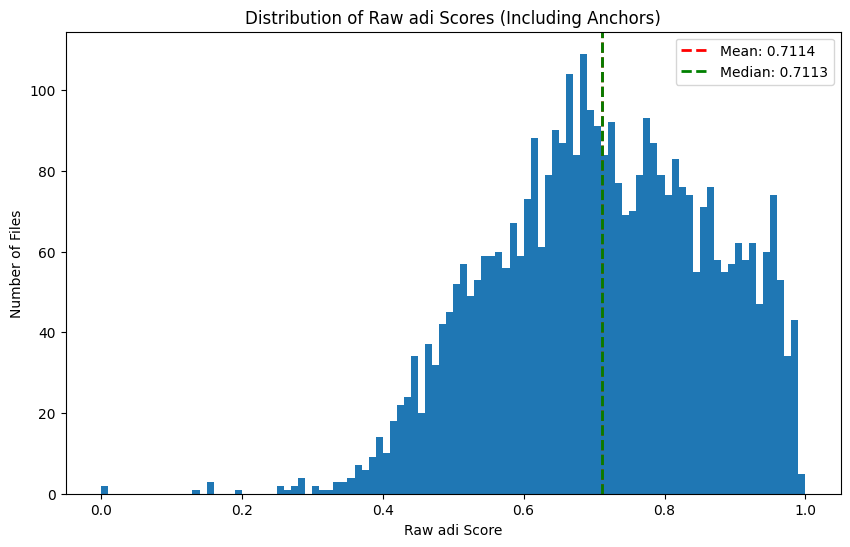

In [13]:
# PLOT THE DISTRIBUTION OF ADI SCORES ACROSS DATASET

print(f"Mean ADI: {np.mean(adi_scores):.4f}")
print(f"Median ADI: {np.median(adi_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.hist(adi_scores, bins=100)
plt.title('Distribution of Raw adi Scores (Including Anchors)')
plt.xlabel('Raw adi Score')
plt.ylabel('Number of Files')
plt.axvline(np.mean(adi_scores), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(adi_scores):.4f}')
plt.axvline(np.median(adi_scores), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(adi_scores):.4f}')
plt.legend()
plt.show()

fig = px.histogram(all_normalized_scores, nbins=100, title="Distribution of Final Normalized ADI Scores (Training Set)")
fig.show()

In [14]:
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# import numpy as np

# def create_distribution_plot(all_scores, user_predicted_score):

#   landmarks = {
#       "Amazon Mean (Training Set)": np.mean(all_scores),
#       "Example: Local Park Placeholder": 0.35,
#       "Example: Damaged Habitat": 0.15
#   }

#   hist_data = [all_scores]
#   group_labels = ['Amazon Training Set Distribution']

#   fig = ff.create_distplot(
#       hist_data,
#       group_labels,
#       bin_size=0.02,
#       show_rug=False,
#       colors=['#1f77b4']
#   )

#   for label, score in landmarks.items():
#     fig.add_vline(
#         x=score,
#         line_width=2,
#         line_dash="dash",
#         line_color="gray",
#         annotation_text=label,
#         annotation_position="top left",
#         annotation_font_size=12
#     )

#   fig.add_vline(
#       x=user_predicted_score,
#       line_width=3,
#       line_dash="solid",
#       line_color="#FF4136",
#       annotation_text=f"Your File's Score: {user_predicted_score:.2f}",
#       annotation_position="top right",
#       annotation_font_size=14,
#       annotation_font_color="#FF4136"
#   )

#   fig.update_layout(
#       title_text="Biodiversity Score Distribution",
#       xaxis_title="Biodiversity Score (0-1 Scale)",
#       yaxis_title="Density",
#       template="plotly_white",
#       legend_title_text="Legend",
#       hovermode="x unified",
#       xaxis=dict(range=[0, 1])
#   )

#   plot_html = fig.to_html(
#       full_html=False,
#       include_plotlyjs='cdn',
#       default_width='100%',
#       default_height='500px'
#   )

#   return plot_html

In [15]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np

def create_distribution_plot(all_scores, user_predicted_score, custom_landmarks=None):

  if custom_landmarks is None:
    landmarks = {
        "Amazon Mean (Training Set)": np.mean(all_scores),
        "Example: Local Park Placeholder": 0.35,
        "Example: Damaged Habitat": 0.15
    }
  else:
    landmarks = custom_landmarks

  hist_data = [all_scores]
  group_labels = ['Amazon Training Set Distribution']

  fig = ff.create_distplot(
      hist_data,
      group_labels,
      bin_size=0.02,
      show_rug=False,
      colors=['#1f77b4']
  )

  annotation_positions = ["top left", "top right", "bottom left", "bottom right"]

  for i, (label, score) in enumerate(landmarks.items()):

    pos = annotation_positions[i % len(annotation_positions)]

    fig.add_vline(
        x=score,
        line_width=2,
        line_dash="dash",
        line_color="gray",
        annotation_text=f"{label}: {score:.2f}",
        annotation_position=pos,
        annotation_font_size=12
    )

  fig.add_vline(
      x=user_predicted_score,
      line_width=3,
      line_dash="solid",
      line_color="#FF4136",
      annotation_text=f"Your File's Score: {user_predicted_score:.2f}",
      annotation_position="top right",
      annotation_font_size=14,
      annotation_font_color="#FF4136"
  )

  fig.update_layout(
      title_text="Biodiversity Score Distribution",
      xaxis_title="Biodiversity Score (0-1 Scale)",
      yaxis_title="Density",
      template="plotly_white",
      legend_title_text="Legend",
      hovermode="x unified",
      xaxis=dict(range=[0, 1])
  )

  plot_html = fig.to_html(
      full_html=False,
      include_plotlyjs='cdn',
      default_width='100%',
      default_height='500px'
  )

  return plot_html

In [16]:
all_normalized_scores = (df_adi['raw_adi'].values - min_adi) / (max_adi - min_adi + 1e-10)
all_normalized_scores = np.clip(all_normalized_scores, 0.0, 1.0)

test_user_score = 0.68

plot_html_string = create_distribution_plot(all_normalized_scores, test_user_score)

from IPython.display import HTML
HTML(plot_html_string)

In [17]:
# print("Loading saved weights from best_model.keras . . .")
# checkpoint_path = "/content/drive/MyDrive/best_model.keras"

# model.load_weights(checkpoint_path)

# print("Weights loaded successfully")

In [18]:
# TRAINING

steps_per_epoch = -(-len(train_files) // BATCH_SIZE)
validation_steps = -(-len(val_files) // BATCH_SIZE)

print("Starting initial training with the base model frozen . . .")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
    #callbacks=[early_stopping]
)

print("Section 1 training complete!")

# FINE TUNING

print("\nUnfreezing the ViT base model for fine-tuning . . .")
model.vit.trainable = True

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    verbose=1,
    min_lr=1e-7
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# checkpoint_path = "/content/drive/MyDrive/best_model.keras"

# model_checkpoint = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

learning_rate = 5e-4

print(f"Re-compiliing model with a much lower learning rate {learning_rate} . . . ")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

print("\nStarting fine-tuning . . .")
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,
    initial_epoch=history.epoch[-1] + 1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler]
    #callbacks=[early_stopping]
)

print("Section 2 fine-tuning was another fat dub")

Starting initial training with the base model frozen . . .
Epoch 1/5
172/237 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - loss: 0.2331 - rmse: 0.2785

/usr/local/lib/python3.12/dist-packages/maad/features/alpha_indices.py:1549: RuntimeWarning:

invalid value encountered in divide



237/237 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - loss: 0.2154 - rmse: 0.2618 - val_loss: 0.1061 - val_rmse: 0.1370
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0985 - rmse: 0.1287 - val_loss: 0.0867 - val_rmse: 0.1166
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0910 - rmse: 0.1189 - val_loss: 0.0876 - val_rmse: 0.1167
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0898 - rmse: 0.1175 - val_loss: 0.0869 - val_rmse: 0.1136
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0868 - rmse: 0.1138 - val_loss: 0.0829 - val_rmse: 0.1104
Section 1 training complete!

Unfreezing the ViT base model for fine-tuning . . .
Re-compiliing model with a much lower learning rate 0.0005 . . . 

Starting fine-tuning . . .
Epoch 6/75
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - loss: 0.0813 - rmse: 0.1090 - val_loss: 0.0825 - val_rmse: 0.1111 - learning_rate: 5.0000e-04
Epoch 7/75
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0818 - rmse: 0.1081 -

Successfully loaded audio file


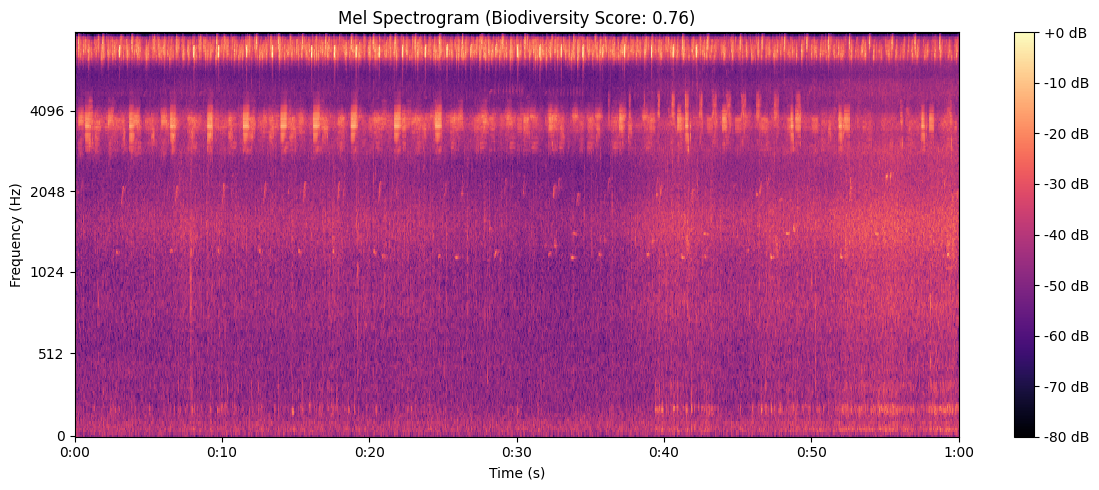

In [19]:
# VISUALIZE MEL AUDIO SPECTROGRAM FOR SINGLE FLAC TO CONFIRM NO ISSUES

#path_to_audio_file = "/content/000316da7.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/00d442df7.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/0072f0839.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/011f25080.flac"

# LETS BOWL
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bowling_alley.flac"

# BLANK FILE
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/blank.flac"

# LOW SCORE
#path_to_audio_file = "/content/rfcx_local_data/rfcx-species-audio-detection/train/e48bf871c.flac"

# path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/blank.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/airport_baggage.flac"
# path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bowling_alley.flac"
# path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/bus.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/laundromat.flac"
# path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/subway.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/urban_park_birds.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/anchor/wind_stairwell.flac"

path_to_audio_file = "/content/rfcx_local_data/rfcx-species-audio-detection/train/eb62e367c.flac"

# GLITCHED AUDIO FILE, WAS THE HIGHEST SCORE BACK WHEN WE USED ACI
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/288e5d13f.flac"
#path_to_audio_file = "/content/7e14bfa8e.flac"
#path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/716dccfed.flac"

try:
  audio_np, sr = librosa.load(path_to_audio_file, sr=16000)
  print("Successfully loaded audio file")
except Exception as e:
  print(f"Error loading file: {e}")
  audio_np = np.zeros(16000 * 60)
  sr = 16000

mel_spectrogram = librosa.feature.melspectrogram(
    y=audio_np, sr=16000, n_fft=2048, hop_length=512, n_mels=224
)

log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
log_mel_spectrogram = np.nan_to_num(log_mel_spectrogram)

raw_adi_score = calculate_adi(audio_np, sr)

normalized_score = (raw_adi_score - min_adi) / (max_adi - min_adi + 1e-10)
normalized_score = np.clip(normalized_score, 0, 1)

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    log_mel_spectrogram,
    sr=16000,
    x_axis='time',
    y_axis='mel',
    fmax=8000
    #cmap='jet'
)


plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram (Biodiversity Score: {normalized_score:.2f})')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

In [20]:
TEST_FLAC_PATH = "/content/rfcx_local_data/rfcx-species-audio-detection/test/"
test_files = sorted(glob.glob(TEST_FLAC_PATH + "*.flac"))

test_paths_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = (
    test_paths_ds.map(load_and_process_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .map(normalize_label, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(test_ds)

print("\n--- Test Results ---")
print(f"Test Loss (MAE): {results[0]:.4f}")
print(f"Test Metric (MAE): {results[1]:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - loss: 0.0645 - rmse: 0.0904

--- Test Results ---
Test Loss (MAE): 0.0628
Test Metric (MAE): 0.0868


In [21]:
def get_anchor_scores(model, anchor_files_list, feature_extractor, all_normalized_scores):
  print("Calculating real landmark scores for anchor files . . .")

  real_landmarks = {

      "Amazon Mean (Training Set)": np.mean(all_normalized_scores)
  }

  for file_path in anchor_files_list:
    try:
      # 1. load audio
      audio, sr = librosa.load(file_path, sr=16000, duration=60)

      # 2. create mel spectrogram
      mel_spec = librosa.feature.melspectrogram(y=audio, sr=16000)
      log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
      log_mel_spec = np.nan_to_num(log_mel_spec)

      # 3. convert to 3 channel and resize
      spec_rgb = np.stack((log_mel_spec,)*3, axis=-1)
      resized_spec_rgb = tf.image.resize(spec_rgb, [224, 224]).numpy()

      # 4. use feature extractor
      inputs = feature_extractor(images=resized_spec_rgb, return_tensors='np', do_rescale=False, do_resize=False)
      pixel_values = np.squeeze(inputs['pixel_values'], axis=0)
      pixel_values = np.moveaxis(pixel_values, 0, -1)

      # 5. add batch dimension for prediction
      img_array_for_pred = np.expand_dims(pixel_values, axis=0)

      # 6. get model prediction
      predicted_score = model.predict(img_array_for_pred, verbose=0)[0][0]

      # 7. clean up the filename for label
      clean_name = os.path.basename(file_path).replace('.flac', '').replace('_', ' ').title()

      # add to dictionary
      real_landmarks[clean_name] = float(predicted_score)

      print(f"   - {clean_name}: {predicted_score:.4f}")

    except Exception as e:
      print(f"Warning: Could not process anchor file {file_path}, error {e}")

  print("Landmark scores calculated")
  return real_landmarks


Running full prediction loop to get labels and predictions . . .
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step

--- Files with big boy scores:
                                                                       filename  \
446  /content/rfcx_local_data/rfcx-species-audio-detection/train/e5001ade8.flac   
744  /content/rfcx_local_data/rfcx-species-audio-detection/train/f4dd82c85.flac   
288  /content/rfcx_local_data/rfcx-species-audio-detection/train/dca449f04.flac   
106  /content/rfcx_local_data/rfcx-species-audio-detection/train/d369de3f0.flac   
478  /content/rfcx_local_data/rfcx-species-audio-detection/train/e694ebc3b.flac   

     true_score  pred_score  
446    0.989166    0.995822  
744    0.982447    0.995611  
288    0.985015    0.995520  
106    0.987787    0.993684  
478    0.965722    0.992497  

--- Files with teeny tiny scores:
                                                                       filename  \
650  /content/rfcx_local_data/rfcx-species-audio-detection/train

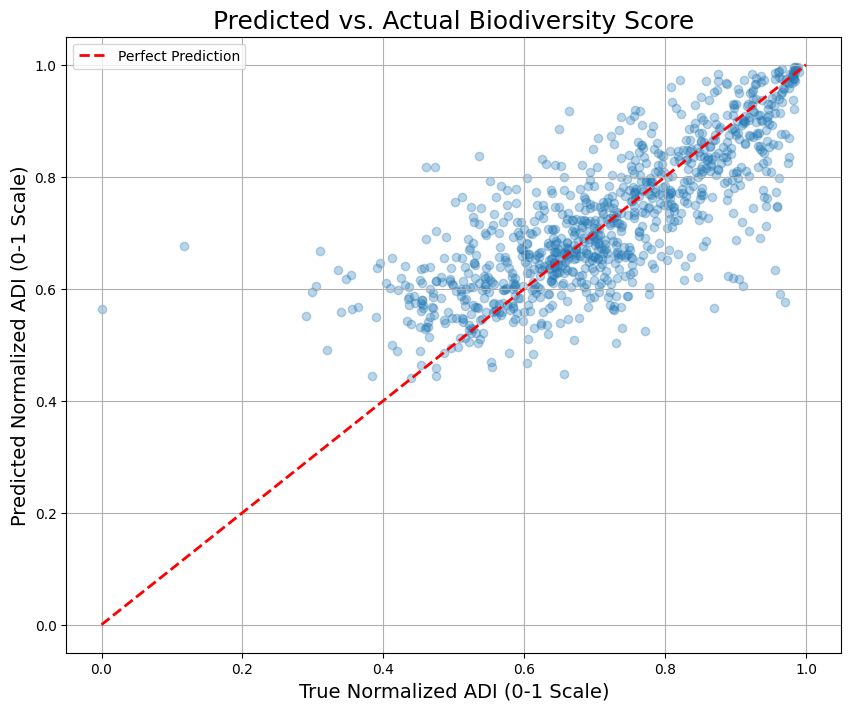

In [22]:
from sklearn.metrics import r2_score, mean_squared_error

print("Running full prediction loop to get labels and predictions . . .")

y_pred_normalized = model.predict(val_ds)

y_true_normalized = []

for features, labels in val_ds.as_numpy_iterator():
  y_true_normalized.extend(labels)

y_true_normalized = np.array(y_true_normalized)
y_pred_normalized = np.squeeze(y_pred_normalized)

df_results = pd.DataFrame({
    'filename': val_files,
    'true_score': y_true_normalized,
    'pred_score': y_pred_normalized
})

print("\n--- Files with big boy scores:")
print(df_results.sort_values(by='pred_score', ascending=False).head())

print("\n--- Files with teeny tiny scores:")
print(df_results.sort_values(by='pred_score', ascending=False).tail())

print("\n--- Final Model Performance Metrics ---")

r2 = r2_score(y_true_normalized, y_pred_normalized)
print(f"R-Squared (R2): {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_true_normalized, y_pred_normalized))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(y_true_normalized - y_pred_normalized)):.4f}")

print("\nGenerating 'Predicted vs. Actual' Plot . . . ")

plt.figure(figsize=(10, 8))
plt.scatter(y_true_normalized, y_pred_normalized, alpha=0.3)

perfect_line = np.linspace(0, 1, 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel('True Normalized ADI (0-1 Scale)', fontsize=14)
plt.ylabel('Predicted Normalized ADI (0-1 Scale)', fontsize=14)
plt.title('Predicted vs. Actual Biodiversity Score', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()


Generating 'Residuals' plot . . . 


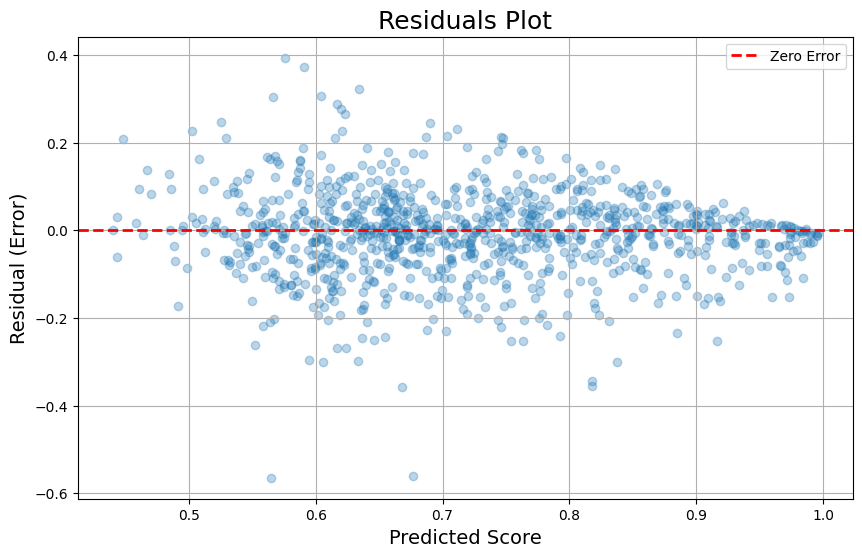

In [23]:
print("\nGenerating 'Residuals' plot . . . ")

residuals = y_true_normalized - y_pred_normalized

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_normalized, residuals, alpha=0.3)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.xlabel('Predicted Score', fontsize=14)
plt.ylabel('Residual (Error)', fontsize=14)
plt.title('Residuals Plot', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import tensorflow.keras.backend as K
import cv2

def generate_attention_rollout(img_array, model):
  print("\n--- [Running Attention Rollout] ---")
  img_tensor = tf.convert_to_tensor(img_array)

  # 1. get model outputs (score and the tuple of 12 attention maps)
  try:
    final_score_pred, attention_maps = model(img_tensor, training=False, explain=True)
  except Exception as e:
    print(f"ERROR: {e}")
    return np.zeros((img_array.shape[1], img_array.shape[2]), dtype=np.uint8)

  print(f'1. Model output score: {final_score_pred.numpy()[0][0]:.4f}')
  print(f'2. Recieved {len(attention_maps)} attention maps (one for each transformer layer)')

  # 2. start with an identity matrix to aggregate attentions
  rollout = tf.eye(197, 197, batch_shape=[1])

  # 3. iterate through all 12 attention maps
  for i, attention_map in enumerate(attention_maps):
    # attention_map shape is (1, 12, 197, 197) (batch, heads, seq, seq)

    # average across the 12 attention maps
    avg_head_map = tf.reduce_mean(attention_map, axis=1)

    # add identity matrix for the residual connection
    identity = tf.eye(197, 197, batch_shape=[1])
    a_map = avg_head_map + identity

    # normalize
    a_map = a_map / tf.reduce_sum(a_map, axis=-1, keepdims=True)

    # matrix multiply to roll out the attentions
    rollout = tf.matmul(rollout, a_map)

  # 4. get the attention for the [CLS] token with respect to all patch tokens
  # rollout shape is (1, 197, 197)
  # want row 0 (the [CLS] token's view of all other tokens)
  # and want columns 1-196 (all patch tokens)
  cls_attention_to_patches = rollout[:, 0, 1:]

  # 5. reshape to a 14x14 grid
  heatmap = tf.reshape(cls_attention_to_patches, (14, 14))

  # 6. normalize and scale to 0-255
  heatmap = heatmap.numpy()
  heatmap_min = np.min(heatmap)
  heatmap_max = np.max(heatmap)

  print(f"\n--- DEBUG: Raw 14x14 heatmap stats")
  print(f" -- Min Value: {heatmap_min}")
  print(f" -- Max Value: {heatmap_max}")
  print(f" -- Mean Value: {np.mean(heatmap)}\n")

  if (heatmap_max - heatmap_min) > K.epsilon():
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
  else:
    heatmap = np.zeros_like(heatmap)

  heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
  heatmap = (heatmap * 255).astype(np.uint8)

  print("3. Attention rollout heatmap generated successfully and I'm totally not calling my shot")
  return heatmap, final_score_pred.numpy()[0][0]


In [25]:
# cell for backend prediction function

import cv2
import io
import base64


def get_prediction_and_heatmap(audio_file_path, model, feature_extractor, min_adi, max_adi, all_normalized_scores):

  # 1. preprocess audio file
  audio, sr = librosa.load(audio_file_path, sr=16000, duration=60)

  # get the label for display
  raw_score = calculate_adi(audio, sr)
  normalized_score = (raw_score - min_adi) / (max_adi - min_adi + 1e-10)
  normalized_score = np.clip(normalized_score, 0, 1)

  # get the image
  mel_spec = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=2048, hop_length=512, n_mels=224)
  log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
  log_mel_spec_rgb = np.stack((log_mel_spec,) * 3, axis=-1)

  # resize and use feature extractor to get (1, 3, 224, 224) input
  resized_spec = tf.image.resize(log_mel_spec_rgb, [224, 224]).numpy()
  inputs = feature_extractor(images=resized_spec, return_tensors='np', do_rescale=False, do_resize=False)

  # this is the (1, 224, 224, 3) array for Grad-CAM
  img_array_for_cam = np.moveaxis(np.squeeze(inputs['pixel_values'], axis=0), 0, -1)
  img_array_for_cam = np.expand_dims(img_array_for_cam, axis=0)

  # GOAL 1: BIODIVERSITY SCORE
  # GET THIS FROM A SINGLE CALL TO THE GENERATE_ATTENTION_ROLLOUT SO NO CALL 2X
  heatmap, predicted_score = generate_attention_rollout(img_array_for_cam, model)

  #
  # predicted_score = model.predict(img_array_for_cam)[0][0]

  #
  # heatmap = generate_attention_rollout(img_array_for_cam, model)
  # #heatmap = generate_grad_cam_heatmap(img_array_for_cam, model)

  # GOAL 2: MEL SPECTROGRAM IMAGE
  print("Generating spectrogram image (Goal 2) . . .")
  fig_spec, ax_spec = plt.subplots(figsize=(12, 5))
  librosa.display.specshow(
      log_mel_spec, sr=sr, x_axis='time', y_axis='mel',
      fmax=8000, ax=ax_spec, cmap='magma'
  )
  ax_spec.set_title("Mel Spectrogram")

  buf_spec = io.BytesIO()
  fig_spec.savefig(buf_spec, format='png', bbox_inches='tight')
  plt.close(fig_spec)
  spectrogram_b64 = base64.b64encode(buf_spec.getvalue()).decode('utf-8')

  # GOAL 3: HEATMAP
  print("Generating heatmap image (Goal 2) . . .")
  fig_heat, ax_heat = plt.subplots(figsize=(12, 5))

  heatmap_resized = cv2.resize(heatmap, (log_mel_spec.shape[1], log_mel_spec.shape[0]))

  # plot spectrogram in gray as a background
  librosa.display.specshow(
      log_mel_spec, sr=sr, x_axis='time', y_axis='mel',
      fmax=8000, ax=ax_heat, cmap='gray'
  )

  # overlay the heatmap
  ax_heat.imshow(
      heatmap_resized, cmap='jet', alpha=0.6, aspect='auto',
      extent=[0, (log_mel_spec.shape[1]*512) / 16000, 0, 8000], origin='lower'
  )
  ax_heat.set_title(f"Attention Heatmap (Predicted Score: {predicted_score:.2f})")

  buf_heat = io.BytesIO()
  fig_heat.savefig(buf_heat, format='png', bbox_inches='tight')
  plt.close(fig_heat)
  heatmap_b64 = base64.b64encode(buf_heat.getvalue()).decode('utf-8')

  # GOAL 4: PLOTLY DISTRIBUTION OF SCORES W/ LANDMARKS
  plotly_html = create_distribution_plot(all_normalized_scores, predicted_score)

  return {
      "biodiversity_score": float(predicted_score),
      "spectrogram_b64": spectrogram_b64,
      "heatmap_b64": heatmap_b64,
      "distribution_plot_html": plotly_html
  }

--- Starting backend verification test [rocket emoji] ---
Test File: /content/drive/MyDrive/rfcx-species-audio-detection/train/00d442df7.flac


--- [Running Attention Rollout] ---
1. Model output score: 0.6733
2. Recieved 12 attention maps (one for each transformer layer)

--- DEBUG: Raw 14x14 heatmap stats
 -- Min Value: 0.0027034732047468424
 -- Max Value: 0.012941917404532433
 -- Mean Value: 0.0049071842804551125

3. Attention rollout heatmap generated successfully and I'm totally not calling my shot
Generating spectrogram image (Goal 2) . . .
Generating heatmap image (Goal 2) . . .

--- Package generated in 19.12 seconds ---

 --- 1. Biodiversity Score ---
Score: 0.6732696294784546

 --- 2. Spectrogram (Matplotlib) ---
Base64 snippet: iVBORw0KGgoAAAANSUhEUgAABAUAAAHWCAYAAAAPazBSAAAAOn . . .


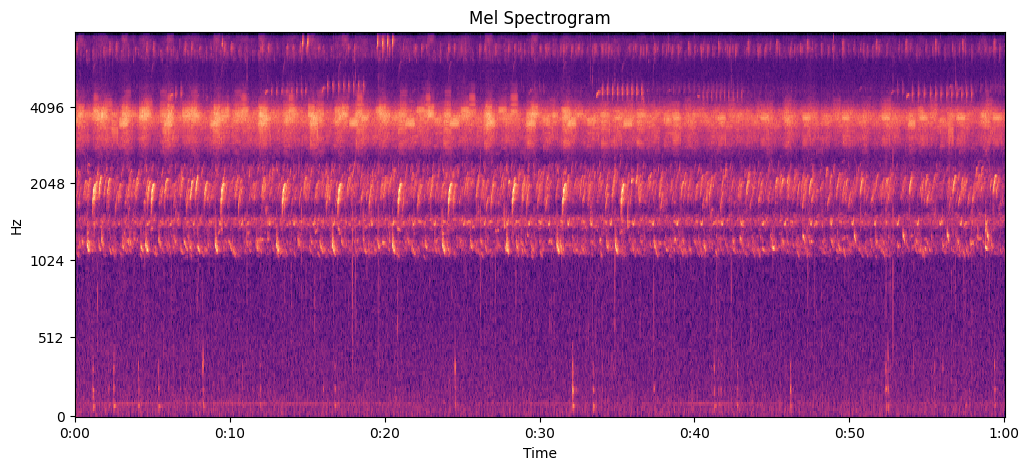


--- 3. Heatmap (Matplotlib) ---
Base64 snippet: iVBORw0KGgoAAAANSUhEUgAABAUAAAHWCAYAAAAPazBSAAAAOn . . .


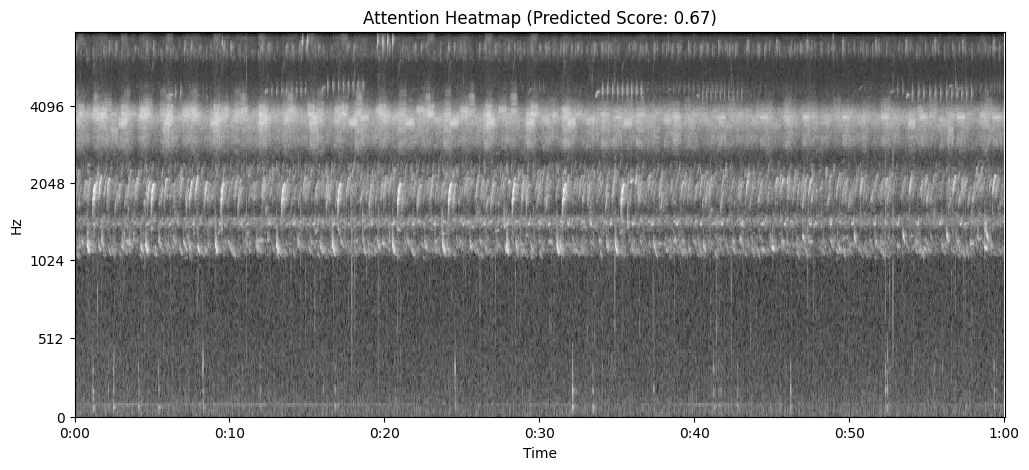


--- 4. Plotly plot (HTML) ---
HTML snippet: <div>                        <script type="text/ja . . .



 Verification complete [trophy emoji]
You should see the score, two images and one interactive plot g


In [26]:
# SMOKE TEST
from IPython.display import display, HTML, Image
import base64
import time

print('--- Starting backend verification test [rocket emoji] ---')
# define inputs
test_file_path = "/content/drive/MyDrive/rfcx-species-audio-detection/train/00d442df7.flac"

print(f"Test File: {test_file_path}\n")

start_time = time.time()

prediction_package = get_prediction_and_heatmap(
    test_file_path,
    model,
    feature_extractor,
    min_adi,
    max_adi,
    all_normalized_scores
)

end_time = time.time()
print(f"\n--- Package generated in {end_time - start_time:.2f} seconds ---")

# verify the 4 outputs

# 1. BIODIVERSITY SCORE
print("\n --- 1. Biodiversity Score ---")
score = prediction_package['biodiversity_score']
print(f"Score: {score}")
assert isinstance(score, float)

# 2. SPECTROGRAM (MATPLOTLIB IMAGE)
print("\n --- 2. Spectrogram (Matplotlib) ---")
spec_b64 = prediction_package['spectrogram_b64']
assert isinstance(spec_b64, str)
print(f"Base64 snippet: {spec_b64[:50]} . . .")
display(Image(data=base64.b64decode(spec_b64)))

# 3. HEATMAP (MATPLOTLIB IMAGE)
print("\n--- 3. Heatmap (Matplotlib) ---")
heat_b64 = prediction_package['heatmap_b64']
assert isinstance(heat_b64, str)
print(f"Base64 snippet: {heat_b64[:50]} . . .")
display(Image(data=base64.b64decode(heat_b64)))

# 4. PLOTLY PLOT (HTML STRING)
print("\n--- 4. Plotly plot (HTML) ---")
plotly_html = prediction_package['distribution_plot_html']
assert isinstance(plotly_html, str)
print(f"HTML snippet: {plotly_html[:50]} . . .")
display(HTML(plotly_html))

print("\n Verification complete [trophy emoji]")
print("You should see the score, two images and one interactive plot g")

In [29]:
# #!pip install opencv-python-headless

# import cv2

# path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/00d442df7.flac"
# #path_to_audio_file = "/content/drive/MyDrive/rfcx-species-audio-detection/train/288e5d13f.flac"

# #high score
# #path_to_audio_file = "/content/rfcx_local_data/rfcx-species-audio-detection/train/eb62e367c.flac"

# # good effort score
# #path_to_audio_file = "/content/rfcx_local_data/rfcx-species-audio-detection/train/e48bf871c.flac"


# print(f"Loading and processing: {path_to_audio_file}")

# try:
#   audio, sr = librosa.load(path_to_audio_file, sr=16000, duration=60)
# except Exception as e:
#   print(f"Warning: Could not load {path_to_audio_file}. Error {e}")
#   audio = np.zeros(16000*60, dtype=np.float32)

# mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=2048, hop_length=512, n_mels=224)
# log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
# log_mel_spectrogram = np.nan_to_num(log_mel_spectrogram)

# spectrogram_rgb = np.stack((log_mel_spectrogram,) * 3, axis=-1)
# resized_spectrogram_rgb = tf.image.resize(spectrogram_rgb, [224, 224]).numpy()

# inputs = feature_extractor(images=resized_spectrogram_rgb, return_tensors='np', do_rescale=False, do_resize=False)
# pixel_values = np.squeeze(inputs['pixel_values'], axis=0)
# pixel_values = np.moveaxis(pixel_values, 0, -1)

# img_array_for_cam = np.expand_dims(pixel_values, axis=0)

# # print("Generating Grad-CAM heatmap . . . ")
# # heatmap = generate_grad_cam_heatmap(
# #     img_array_for_cam,
# #     model
# # )
# print("Generating Attention Rollout heatmap . . .")
# heatmap_image, predicted_score = generate_attention_rollout(
#     img_array_for_cam,
#     model
# )

# print("Plotting results . . .")

# #predicted_score = model.predict(img_array_for_cam, verbose=0)[0][0]

# fig, ax = plt.subplots(figsize=(14, 5))

# HOP_LENGTH = 512
# SR = 16000
# FMAX = 8000
# duration_sec = (log_mel_spectrogram.shape[1]*HOP_LENGTH) / SR

# librosa.display.specshow(
#     log_mel_spectrogram,
#     sr=sr,
#     x_axis='time',
#     y_axis='mel',
#     fmax=8000,
#     ax=ax,
#     cmap='magma',
#     zorder=1
# )

# heatmap_resized = cv2.resize(heatmap_image, (log_mel_spectrogram.shape[1], log_mel_spectrogram.shape[0]))

# ax.imshow(
#     heatmap_resized,
#     cmap='jet',
#     alpha=0.8,
#     aspect='auto',
#     extent=[0, duration_sec, 0, FMAX],
#     origin='lower',
#     zorder=10
# )

# ax.set_title(
#     f"Attention Rollout Heatmap (Predicted Score: {predicted_score:.2f})\n"
#     f"(Red/Yellow = High Attention, Blue = Low Attention)",
#     )
# mappable = ax.collections[0] if ax.collections else ax.images[0]
# plt.colorbar(mappable, ax=ax, format="%+2.0f dB")
# # plt.colorbar(ax.collections[1], format="%+2.0f dB")
# plt.tight_layout()
# plt.show()

In [ ]:
# print("Plotting results. . . ")

# predicted_score = model.predict(img_array_for_cam, verbose=0)[0][0]

# fig, ax = plt.subplots(figsize=(14, 5))

# HOP_LENGTH = 512
# SR = 16000
# FMAX = 8000
# duration_sec = (log_mel_spectrogram.shape[1]*HOP_LENGTH) / SR

# # LAYER 1 SPECTROGRAM
# spec_plot = librosa.display.specshow(
#     log_mel_spectrogram,
#     sr=sr,
#     x_axis='time',
#     y_axis='mel',
#     fmax=8000,
#     ax=ax,
#     cmap='magma',
#     zorder=1
# )

# heatmap_resized = cv2.resize(heatmap, (log_mel_spectrogram.shape[1], log_mel_spectrogram.shape[0]))

# heatmap_plot = ax.imshow(
#     heatmap_resized,
#     cmap='jet',
#     alpha=0.5,
#     aspect='auto',
#     extent=[0, duration_sec, 0, FMAX],
#     origin='lower',
#     zorder=10
# )

# ax.set_title(f"Attention Rollout Heatmap (Predicted Score: {predicted_score:.2f})")

# # COLORBAR 1 SPECTROGRAM
# cbar_spec = plt.colorbar(spec_plot, ax=ax, format="%+2.0f dB")
# cbar_spec.set_label('Spectrogram Power (dB)', rotation=270, labelpad=15)

# # COLORBAR 2 HEATMAP
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad=0.1)

# cbar_heat = plt.colorbar(heatmap_plot, cax=cax)
# cbar_heat.set_label('Attention Weight', rotation=270, labelpad=15)

# cbar_heat.set_ticks([0, 235])
# cbar_heat.set_ticklabels(['Low', 'High'])

# plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.show()
